# LUAD survival analysis

#### Data sources:
- `rna_cancer_sample.tsv`: Human Protein Atlas (https://www.proteinatlas.org/download/rna_cancer_sample.tsv.zip)
- `clinical.tsv`: TCGA (https://portal.gdc.cancer.gov/projects/TCGA-LUAD; click Clinical download button)

### Import dependencies

In [38]:
suppressWarnings({
    library(survival)
    library(survminer)

    setwd("C:/Users/jorda/Desktop/projects/manuscript/rna_cancer_data/")
})

### Read gene expression data and format

In [40]:
rpkm_data <- read.csv(file = 'rna_cancer_sample.tsv', sep='\t')

# Extract LUAD data
rpkm_data <- rpkm_data[rpkm_data$Cancer == 'LUAD',]

# Clean up Sample IDs
rpkm_data$Sample <- sapply(strsplit(rpkm_data$Sample, "-01A"), "[", 1)
gene_list <- unique(rpkm_data$Gene)
rpkm_data$FPKM <- as.numeric(rpkm_data$FPKM)

### Read clinical data and format/censor

In [41]:
clinical_data <- read.csv(file = "clinical.tsv", sep='\t')

# Censor alive==0/dead==1
# See "event" description at https://www.rdocumentation.org/packages/survival/versions/2.11-4/topics/Surv
censor_data <- function(x) if (x == "Alive") {0} else {1}
clinical_data$status <- mapply(censor_data, clinical_data$vital_status)
clinical_data$status <- as.numeric(clinical_data$status)
clinical_data$days_to_death <- as.numeric(clinical_data$days_to_death)

# Right censor for alive
# https://cran.r-project.org/web/packages/finalfit/vignettes/survival.html
clinical_data$days_to_death <- ifelse(
    is.na(clinical_data$days_to_death), 
    clinical_data$days_to_last_follow_up, 
    clinical_data$days_to_death)

# Get relevant data and perform some additional data clean-up
clinical_sample <- clinical_data[ , c("case_submitter_id", "ajcc_pathologic_stage", "status", "days_to_death", "days_to_last_follow_up")] 
clinical_sample <- clinical_sample[clinical_sample$days_to_death > 10 & clinical_sample$days_to_last_follow_up != "'--", ]
clinical_sample <- clinical_sample[clinical_sample$days_to_death != "'--", ]

# Make sure output formatting is correct
clinical_sample$status <- as.numeric(as.character(clinical_sample$status))
clinical_sample$days_to_death <- as.numeric(as.character(clinical_sample$days_to_death))
clinical_sample$days_to_last_follow_up <- as.numeric(as.character(clinical_sample$days_to_last_follow_up))

# Add stage category labels
clinical_sample$stage <- clinical_sample$ajcc_pathologic_stage
clinical_sample <- clinical_sample[clinical_sample$stage != "'--", ]
clinical_sample$stage[
    clinical_sample$stage == "Stage I" | 
    clinical_sample$stage == "Stage IA" | 
    clinical_sample$stage == "Stage IB"] <- 1
clinical_sample$stage[
    clinical_sample$stage == "Stage II" | 
    clinical_sample$stage == "Stage IIA" | 
    clinical_sample$stage == "Stage IIB"] <- 2
clinical_sample$stage[
    clinical_sample$stage == "Stage III" | 
    clinical_sample$stage == "Stage IIIA" | 
    clinical_sample$stage == "Stage IIIB"] <- 3
clinical_sample$stage[
    clinical_sample$stage == "Stage IV" | 
    clinical_sample$stage == "Stage IVA" | 
    clinical_sample$stage == "Stage IVB"] <- 4

# Parse out early vs. late patients
clinical_sample_early <- clinical_sample[
    clinical_sample$ajcc_pathologic_stage == "Stage I" | 
    clinical_sample$ajcc_pathologic_stage == "Stage IA" | 
    clinical_sample$ajcc_pathologic_stage == "Stage IB", ]
clinical_sample_late <- clinical_sample[
    clinical_sample$ajcc_pathologic_stage != "Stage I" & 
    clinical_sample$ajcc_pathologic_stage != "Stage IA" & 
    clinical_sample$ajcc_pathologic_stage != "Stage IB", ]

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


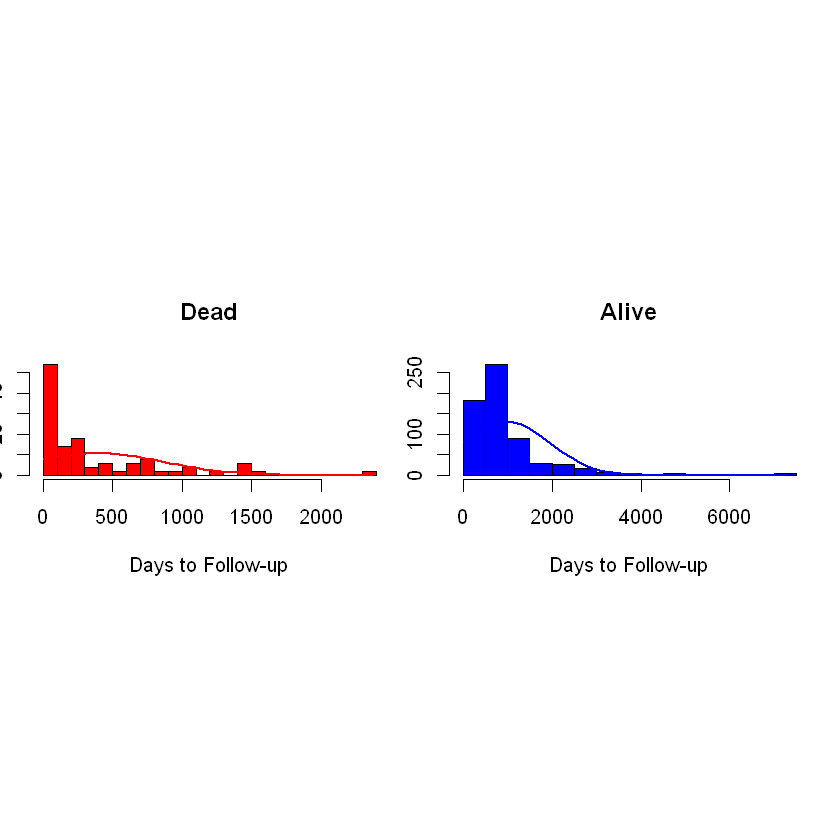

In [42]:
par(mfrow=c(1,2), pin=c(3,1))

x1 <- clinical_sample[clinical_sample$status == 1, ]$days_to_last_follow_up
h1 <-hist(x1, breaks=20, col="red", xlab="Days to Follow-up", main="Dead")
xfit1<-seq(min(x1),max(x1),length=40)
yfit1<-dnorm(xfit1,mean=mean(x1),sd=sd(x1))
yfit1 <- yfit1*diff(h1$mids[1:2])*length(x1)
lines(xfit1, yfit1, col="red", lwd=2)

x2 <- clinical_sample[clinical_sample$status == 0, ]$days_to_last_follow_up
h2 <- hist(x2, breaks=20, col="blue", xlab="Days to Follow-up", main="Alive")
xfit2<-seq(min(x2),max(x2),length=40)
yfit2<-dnorm(xfit2,mean=mean(x2),sd=sd(x2))
yfit2 <- yfit2*diff(h2$mids[1:2])*length(x2)
lines(xfit2, yfit2, col="blue", lwd=2)

In [43]:
head(clinical_sample)

,case_submitter_id,ajcc_pathologic_stage,status,days_to_death,days_to_last_follow_up,stage
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
3,TCGA-86-8674,Stage IIA,0,806,806,2
4,TCGA-86-8674,Stage IIA,0,806,806,2
7,TCGA-91-7771,Stage IIB,0,492,492,2
8,TCGA-91-7771,Stage IIB,0,492,492,2
9,TCGA-55-A491,Stage IA,0,626,626,1
10,TCGA-55-A491,Stage IA,0,626,626,1


### Perform analysis on all genes

#### All stages

In [ ]:
median_pvals <-list()
optimized_pvals <- list()
counter <- 0

for (this_gene in gene_list) {
  tryCatch({
    data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
    # Merged mixed data tables
    merged_data_gene <- merge(
      data_gene,
      clinical_sample,
      by.x = "Sample",
      by.y = "case_submitter_id")

    this_median <- median(merged_data_gene$FPKM)
    merged_data_gene$gene_status <- ifelse(merged_data_gene$FPKM > this_median, "high", "low")

    km_trt_fit <- survfit(Surv(days_to_death, status) ~ gene_status, data=merged_data_gene)

    opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
    # print(c(this_gene, opt_cutoff))
    opt_categories <- surv_categorize(opt_cutoff)
    opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)

    median_pvals[this_gene] <- surv_pvalue(km_trt_fit)$pval
    optimized_pvals[this_gene] <- surv_pvalue(opt_fit)$pval
  }, error = function (condition) {
    counter <- counter + 1
    #print(this_gene)
    #print(condition)
    #break
  })
}

print(paste("Skipped", counter, "genes", sep=" "))

#### Early stages

In [ ]:
median_pvals_early <-list()
optimized_pvals_early <- list()
counter <- 0

for (this_gene in gene_list) {
  tryCatch({
    data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
    # Merged mixed data tables
    merged_data_gene <- merge(
      data_gene,
      clinical_sample_early,
      by.x = "Sample",
      by.y = "case_submitter_id")

    this_median <- median(merged_data_gene$FPKM)
    merged_data_gene$gene_status <- ifelse(merged_data_gene$FPKM > this_median, "high", "low")

    km_trt_fit <- survfit(Surv(days_to_death, status) ~ gene_status, data=merged_data_gene)

    opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
    # print(c(this_gene, opt_cutoff))
    opt_categories <- surv_categorize(opt_cutoff)
    opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)

    median_pvals_early[this_gene] <- surv_pvalue(km_trt_fit)$pval
    optimized_pvals_early[this_gene] <- surv_pvalue(opt_fit)$pval
  }, error = function (condition) {
    counter <- counter + 1
    #print(this_gene)
    #print(condition)
    #break
  })
}

print(paste("Skipped", counter, "genes", sep=" "))

#### Late stages

In [ ]:
median_pvals_late <-list()
optimized_pvals_late <- list()
counter <- 0

for (this_gene in gene_list) {
  tryCatch({
    data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
    # Merged mixed data tables
    merged_data_gene <- merge(
      data_gene,
      clinical_sample_late,
      by.x = "Sample",
      by.y = "case_submitter_id")

    this_median <- median(merged_data_gene$FPKM)
    merged_data_gene$gene_status <- ifelse(merged_data_gene$FPKM > this_median, "high", "low")

    km_trt_fit <- survfit(Surv(days_to_death, status) ~ gene_status, data=merged_data_gene)

    opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
    # print(c(this_gene, opt_cutoff))
    opt_categories <- surv_categorize(opt_cutoff)
    opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)

    median_pvals_late[this_gene] <- surv_pvalue(km_trt_fit)$pval
    optimized_pvals_late[this_gene] <- surv_pvalue(opt_fit)$pval
  }, error = function (condition) {
    counter <- counter + 1
    #print(this_gene)
    #print(condition)
    #break
  })
}

print(paste("Skipped", counter, "genes", sep=" "))

### SMS (ENSG00000102172)

In [ ]:
this_gene <- "ENSG00000102172"

#### All stages

In [ ]:
# K-M Curve
data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
# Merged mixed data tables
merged_data_gene <- merge(
  data_gene,
  clinical_sample,
  by.x = "Sample",
  by.y = "case_submitter_id")

opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
opt_categories <- surv_categorize(opt_cutoff)
opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)

sms_val <- surv_pvalue(opt_fit)$pval

#pdf('SMS_all_km.pdf')
ggsurvplot(
  opt_fit,
  risk.table = TRUE,
  conf.int=TRUE,
  pval=sms_val,
  pval.method=TRUE,
  palette=c("dodgerblue2", "orchid2"),
  title="Kaplan-Meier Curve for Lung Cancer Survival",
  risk.table.height=.25)

# Cox Regression
data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
# Merged mixed data tables
merged_data_gene <- merge(
  data_gene,
  clinical_sample,
  by.x = "Sample",
  by.y = "case_submitter_id")
opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
opt_categories <- surv_categorize(opt_cutoff)
opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)
res.cox <- coxph(Surv(days_to_death, status) ~ FPKM, data=opt_categories)
summary(res.cox)

#### Early samples

In [ ]:
# K-M Curve
data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
# Merged mixed data tables
merged_data_gene <- merge(
  data_gene,
  clinical_sample_early,
  by.x = "Sample",
  by.y = "case_submitter_id")

opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
opt_categories <- surv_categorize(opt_cutoff)
opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)

sms_val <- surv_pvalue(opt_fit)$pval

#pdf('SMS_early_km.pdf')
ggsurvplot(
  opt_fit,
  risk.table = TRUE,
  conf.int=TRUE,
  pval=sms_val,
  pval.method=TRUE,
  palette=c("dodgerblue2", "orchid2"),
  title="Kaplan-Meier Curve for Lung Cancer Survival",
  risk.table.height=.25)

# Cox Regression
data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
# Merged mixed data tables
merged_data_gene <- merge(
  data_gene,
  clinical_sample_early,
  by.x = "Sample",
  by.y = "case_submitter_id")
opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
opt_categories <- surv_categorize(opt_cutoff)
opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)
res.cox <- coxph(Surv(days_to_death, status) ~ FPKM, data=opt_categories)
summary(res.cox)

#### Late samples

In [ ]:
# K-M Curve
data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
# Merged mixed data tables
merged_data_gene <- merge(
  data_gene,
  clinical_sample_late,
  by.x = "Sample",
  by.y = "case_submitter_id")

opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
opt_categories <- surv_categorize(opt_cutoff)
opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)

sms_val <- surv_pvalue(opt_fit)$pval

#pdf('SMS_late_km.pdf')
ggsurvplot(
  opt_fit,
  risk.table = TRUE,
  conf.int=TRUE,
  pval=sms_val,
  pval.method=TRUE,
  palette=c("dodgerblue2", "orchid2"),
  title="Kaplan-Meier Curve for Lung Cancer Survival",
  risk.table.height=.25)

# Cox Regression 
data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
# Merged mixed data tables
merged_data_gene <- merge(
  data_gene,
  clinical_sample_late,
  by.x = "Sample",
  by.y = "case_submitter_id")
opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
opt_categories <- surv_categorize(opt_cutoff)
opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)
res.cox <- coxph(Surv(days_to_death, status) ~ FPKM, data=opt_categories)
summary(res.cox)

### GLYCTK (ENSG00000168237)

In [ ]:
this_gene <- "ENSG00000168237"

#### All stages

In [ ]:
# K-M Curve
data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
# Merged mixed data tables
merged_data_gene <- merge(
  data_gene,
  clinical_sample,
  by.x = "Sample",
  by.y = "case_submitter_id")

opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
opt_categories <- surv_categorize(opt_cutoff)
opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)

sms_val <- surv_pvalue(opt_fit)$pval

#pdf('GLYCTK_all_km.pdf')
ggsurvplot(
  opt_fit,
  risk.table = TRUE,
  conf.int=TRUE,
  pval=sms_val,
  pval.method=TRUE,
  palette=c("dodgerblue2", "orchid2"),
  title="Kaplan-Meier Curve for Lung Cancer Survival",
  risk.table.height=.25)

# Cox Regression
data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
# Merged mixed data tables
merged_data_gene <- merge(
  data_gene,
  clinical_sample,
  by.x = "Sample",
  by.y = "case_submitter_id")
opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
opt_categories <- surv_categorize(opt_cutoff)
opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)
res.cox <- coxph(Surv(days_to_death, status) ~ FPKM, data=opt_categories)
summary(res.cox)

#### Early samples

In [ ]:
# K-M Curve
data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
# Merged mixed data tables
merged_data_gene <- merge(
  data_gene,
  clinical_sample_early,
  by.x = "Sample",
  by.y = "case_submitter_id")

opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
opt_categories <- surv_categorize(opt_cutoff)
opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)

sms_val <- surv_pvalue(opt_fit)$pval

#pdf('GLYCTK_early_km.pdf')
ggsurvplot(
  opt_fit,
  risk.table = TRUE,
  conf.int=TRUE,
  pval=sms_val,
  pval.method=TRUE,
  palette=c("dodgerblue2", "orchid2"),
  title="Kaplan-Meier Curve for Lung Cancer Survival",
  risk.table.height=.25)

# Cox Regression
data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
# Merged mixed data tables
merged_data_gene <- merge(
  data_gene,
  clinical_sample_early,
  by.x = "Sample",
  by.y = "case_submitter_id")
opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
opt_categories <- surv_categorize(opt_cutoff)
opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)
res.cox <- coxph(Surv(days_to_death, status) ~ FPKM, data=opt_categories)
summary(res.cox)

#### Late samples

In [ ]:
# K-M Curve
data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
# Merged mixed data tables
merged_data_gene <- merge(
  data_gene,
  clinical_sample_late,
  by.x = "Sample",
  by.y = "case_submitter_id")

opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
opt_categories <- surv_categorize(opt_cutoff)
opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)

sms_val <- surv_pvalue(opt_fit)$pval

#pdf('GLYCTK_late_km.pdf')
ggsurvplot(
  opt_fit,
  risk.table = TRUE,
  conf.int=TRUE,
  pval=sms_val,
  pval.method=TRUE,
  palette=c("dodgerblue2", "orchid2"),
  title="Kaplan-Meier Curve for Lung Cancer Survival",
  risk.table.height=.25)

# Cox Regression 
data_gene <- rpkm_data[rpkm_data$Gene == this_gene,]
# Merged mixed data tables
merged_data_gene <- merge(
  data_gene,
  clinical_sample_late,
  by.x = "Sample",
  by.y = "case_submitter_id")
opt_cutoff <- surv_cutpoint(merged_data_gene, time = "days_to_death", event = "status", variables = c("FPKM"))
opt_categories <- surv_categorize(opt_cutoff)
opt_fit <- survfit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)
res.cox <- coxph(Surv(days_to_death, status) ~ FPKM, data=opt_categories)
summary(res.cox)

### Rank order survival p-values

In [ ]:
# Get ranked percentile
optimized_pvals_sorted <- optimized_pvals[order(unlist(optimized_pvals), decreasing=FALSE)]
ptimized_pvals_early_sorted <- optimized_pvals_early[order(unlist(optimized_pvals_early), decreasing=FALSE)]
optimized_pvals_late_sorted <- optimized_pvals_late[order(unlist(optimized_pvals_late), decreasing=FALSE)]

In [ ]:
bump <- 1e-5

#### All stages

In [ ]:
# Plot distribution
optimized_pvals_bh <- p.adjust(
  optimized_pvals_sorted, 
  method = "BH", 
  n = length(optimized_pvals_sorted))

#pdf('bh_dist_all.pdf')
hist(
  -1 * log10(as.numeric(optimized_pvals_bh) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(optimized_pvals_bh['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(optimized_pvals_bh['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)

#### Early Stage

In [ ]:
# Plot distribution
optimized_pvals_bh_early <- p.adjust(
  ptimized_pvals_early_sorted, 
  method = "BH", 
  n = length(ptimized_pvals_early_sorted))

#pdf('bh_dist_early.pdf')
hist(
  -1 * log10(as.numeric(optimized_pvals_bh_early) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(optimized_pvals_bh_early['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(optimized_pvals_bh_early['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)

#### Late Stage

In [ ]:
# Plot distribution
optimized_pvals_bh_late <- p.adjust(
  optimized_pvals_late_sorted, 
  method = "BH", 
  n = length(optimized_pvals_late_sorted))

#pdf('bh_dist_late.pdf')
hist(
  -1 * log10(as.numeric(optimized_pvals_bh_late) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(optimized_pvals_bh_late['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(optimized_pvals_bh_late['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)

### Session Info

In [ ]:
sessionInfo()